In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
import statistics
import seaborn as sns
import sklearn

In [2]:
data = pd.read_excel(r'C:\Users\user\Downloads\4.1\Project\Data files\Price_data.xlsx')
data.head()

,Date,Tomatoes,Kales,Cabbages
0,2012-01-01,3411.0,1328.0,2205.0
1,2012-02-01,4100.0,1985.0,2739.0
2,2012-03-01,3685.0,2049.0,3049.0
3,2012-04-01,2820.0,1580.0,2625.0
4,2012-05-01,3302.0,1206.0,2105.0


In [3]:
df = pd.DataFrame()
df['Tomatoes']=data['Tomatoes']
df['Kales']=data['Kales']
df['Cabbages']=data['Cabbages']
df['Date']= pd.to_datetime(data['Date'])
df=df.set_index('Date')

df.tail()

,Tomatoes,Kales,Cabbages
Date,,,
2020-08-01,3400.0,1100.0,1400.0
2020-09-01,3200.0,900.0,1400.0
2020-10-01,3600.0,1100.0,900.0
2020-11-01,1820.0,900.0,1000.0
2020-12-01,1860.0,700.0,841.0


In [4]:
#LOCATING ROWS WITH NULL VALUES
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

rows_with_NaN

,Tomatoes,Kales,Cabbages
Date,,,
2019-12-01,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN


In [5]:
Tomatoes = df['Tomatoes']
df['Tomatoes_roll']= Tomatoes.rolling(min_periods=1,window=3).mean()
df = df.apply(lambda x: x.fillna(df['Tomatoes_roll']) if x.name in['Tomatoes','Tomatoes_roll'] else x)

In [6]:
Kales = df['Kales']
df['Kales_roll']= Kales.rolling(min_periods=1,window=3).mean()
df = df.apply(lambda x: x.fillna(df['Kales_roll']) if x.name in['Kales','Kales_roll'] else x)

In [7]:
Cabbages = df['Cabbages']
df['Cabbages_roll']= Cabbages.rolling(min_periods=1,window=3).mean()
df = df.apply(lambda x: x.fillna(df['Cabbages_roll']) if x.name in['Cabbages','Cabbages_roll'] else x)

In [8]:
df.isnull().any()

Tomatoes         False
Kales            False
Cabbages         False
Tomatoes_roll    False
Kales_roll       False
Cabbages_roll    False
dtype: bool

64kg box of  tomatoes
50kg bag of kales
126kg bag of cabbages

In [9]:
df=df.drop(['Tomatoes_roll','Kales_roll','Cabbages_roll'],axis=1)

df['Tomatoes']=df['Tomatoes']/64
df['Kales']=df['Kales']/50
df['Cabbages']=df['Cabbages']/126
df.head()

,Tomatoes,Kales,Cabbages
Date,,,
2012-01-01,53.296875,26.56,17.500000
2012-02-01,64.062500,39.70,21.738095
2012-03-01,57.578125,40.98,24.198413
2012-04-01,44.062500,31.60,20.833333
2012-05-01,51.593750,24.12,16.706349


In [10]:
df=df.round(decimals=2)
df.head()

,Tomatoes,Kales,Cabbages
Date,,,
2012-01-01,53.30,26.56,17.50
2012-02-01,64.06,39.70,21.74
2012-03-01,57.58,40.98,24.20
2012-04-01,44.06,31.60,20.83
2012-05-01,51.59,24.12,16.71


In [11]:
def check_for_stationarity(data):
    
    #Determining rolling statistics
    rolmean = data.rolling(12).mean()
    rolstd = data.rolling(12).std()
#Plot rolling statistics:
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform ADF Statistic test:
    result = adfuller(data,autolag='aic')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

C:\Users\user\Downloads\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


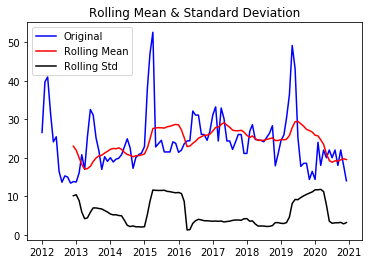

ADF Statistic: -5.042825155530692
p-value: 1.8246104754637647e-05
Critical Values:
	1%: -3.4936021509366793
	5%: -2.8892174239808703
	10%: -2.58153320754717


In [12]:
check_for_stationarity(df['Kales'])

The null hypothesis is that the time series is non-stationary

The p-value is lower than the significance level of 0.05 ADF statistic is lower than all the critical values 

Hence reject the null hypothesis and conclude that the series is stationary 

KALES

In [13]:
Kales=pd.DataFrame()
Kales['Date'] = pd.to_datetime(data['Date'])
Kales = Kales.set_index('Date')
Kales['Kales'] = df['Kales']
Kales.isnull().any()

Kales    False
dtype: bool

In [14]:
df_Kales=Kales.drop(Kales.index[-12:])

In [15]:
df_seasonal = df_Kales.copy()
df_seasonal['Year'] = df_Kales.index.year
df_seasonal['Month'] = df_Kales.index.month

df_seasonal.tail()

,Kales,Year,Month
Date,,,
2019-08-01,17.75,2019,8
2019-09-01,18.55,2019,9
2019-10-01,18.55,2019,10
2019-11-01,14.35,2019,11
2019-12-01,16.45,2019,12


In [16]:
months = df_seasonal.groupby('Month').agg({'Kales':['mean','min','max']})
months = months.round(decimals=2)
months

Kales              
        mean    min    max
Month                     
1      22.65  13.70  31.10
2      27.59  16.08  39.70
3      29.39  19.60  47.00
4      29.93  16.96  52.60
5      27.70  20.80  49.16
6      28.58  22.87  43.12
7      25.24  16.48  31.12
8      22.38  13.64  31.07
9      21.35  15.28  26.40
10     21.56  14.98  28.31
11     20.17  13.40  26.02
12     20.41  13.80  26.88

In [17]:
mont=df_seasonal.groupby('Month').std()
mont=mont.round(decimals=2)
mont

,Kales,Year
Month,,
1,5.09,2.45
2,8.70,2.45
3,9.82,2.45
4,11.30,2.45
5,9.07,2.45
6,6.97,2.45
7,4.60,2.45
8,5.21,2.45
9,4.08,2.45


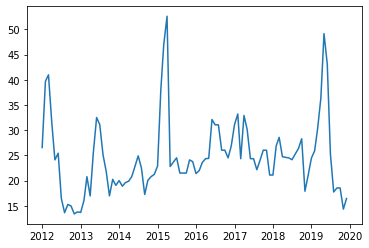

In [18]:
plt.plot(df_Kales)

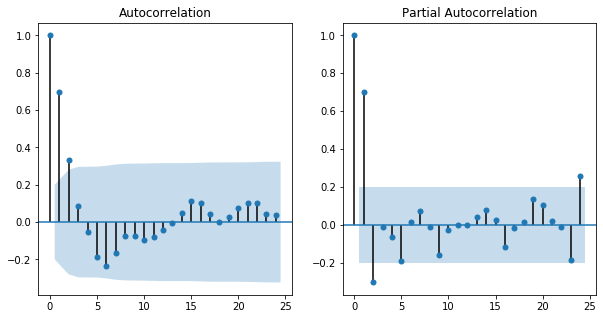

In [19]:
import statsmodels.api as sm

fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(df_Kales.squeeze(), lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_Kales.squeeze(), lags=24, ax=ax[1])
plt.show()

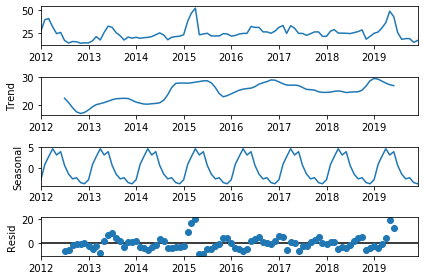

In [20]:
decomp_results = seasonal_decompose(df_Kales, model='additive',period=12)
type(decomp_results)

residuals = decomp_results.resid
residuals.dropna(inplace=True)

decomp_results.plot()
plt.show()

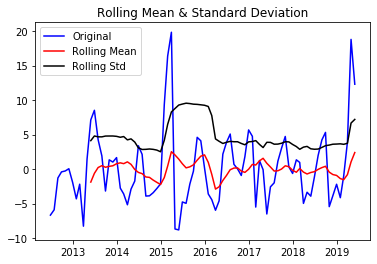

ADF Statistic: -5.595607420862784
p-value: 1.2991806082919646e-06
Critical Values:
	1%: -3.5159766913976376
	5%: -2.898885703483903
	10%: -2.5866935058484217


In [21]:
check_for_stationarity(residuals)

residuals are stationary since the ADF Statistic of -6.38479< all the critical values

In [22]:
 #Perform ADF Statistic test:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    adf = adfuller(data,autolag='aic')
    print('ADF Statistic: {}'.format(adf[0]))
    print('p-value: {}'.format(adf[1]))
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t{}: {}'.format(key, value))

KPSS Test
Null hypothesis: process is trend stationary
Alternate hypotheis: the series has a unit root hence not stationary

from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test statistic','p-value','Lags used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical value (%s)'%key] =  value
    print(kpss_output)

kpss_test(df_Kales)

If the test statistic is greater than the critical value,  we reject the null hypothesis (series is not stationary)
0.125299< all critical values

KPSS test = stationary| ADF test  = stationary

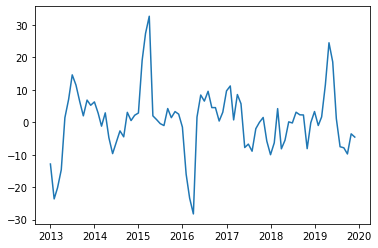

In [23]:
#SEASONAL DIFFERENCING m=12
diff_Kales=  pd.DataFrame()
diff_Kales = df_Kales.diff(12)
diff_Kales.dropna(inplace=True)

plt.plot(diff_Kales)
plt.show()

In [24]:
diff_Kales.head()

,Kales
Date,
2013-01-01,-12.86
2013-02-01,-23.62
2013-03-01,-20.20
2013-04-01,-14.64
2013-05-01,1.42


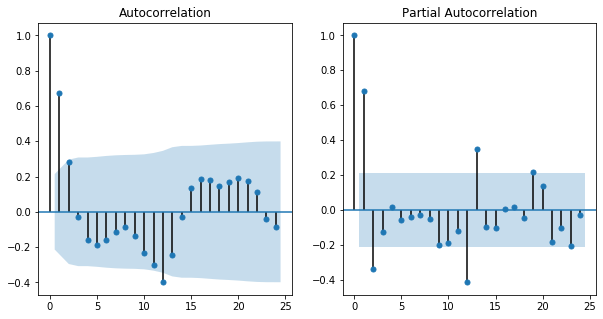

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(diff_Kales.squeeze(), lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_Kales.squeeze(), lags=24, ax=ax[1])
plt.show()

ACF has significant spikes at lags 1 and 12
PACF has a sgnificant spike at lag (p) and spikes continue to occur after lag 1... no clarity in seasonal MA order

In [26]:
from statsmodels.graphics.tsaplots import acf, pacf

def acf_pacf(data):
    lag_acf = acf(data)
    lag_pacf = pacf(data)
#Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

#Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


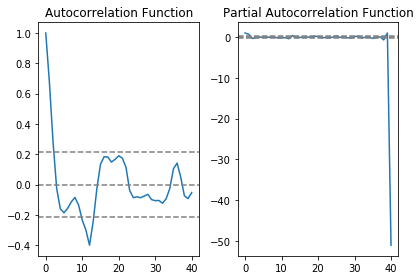

In [27]:
acf_pacf(diff_Kales)

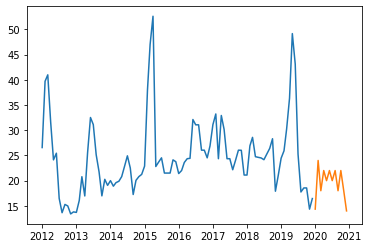

In [28]:
train =Kales[:96]
test = Kales[-12:]
plt.plot(train)
plt.plot(test)

SARIMA

In [29]:
# fit stepwise auto-ARIMA
arima_fit = pm.auto_arima(df_Kales, start_p=0, start_q=1,
                             max_p=1, max_q=1, m=12,
                             start_P=0, seasonal=True,
                             d=0, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


Performing stepwise search to minimize aic
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=551.437, BIC=561.160, Time=1.825 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=629.555, BIC=634.417, Time=0.012 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=562.649, BIC=572.372, Time=0.792 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=627.787, BIC=630.217, Time=0.043 seconds
Fit ARIMA(0,0,1)x(0,1,0,12) [intercept=True]; AIC=587.794, BIC=595.086, Time=0.099 seconds
Fit ARIMA(0,0,1)x(1,1,1,12) [intercept=True]; AIC=552.548, BIC=564.702, Time=0.882 seconds
Near non-invertible roots for order (0, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,1)x(0,1,2,12) [intercept=True]; AIC=552.347, BIC=564.501, Time=2.497 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
F

In [30]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -267.132
Date:                            Fri, 11 Jun 2021   AIC                            544.264
Time:                                    12:06:36   BIC                            556.418
Sample:                                         0   HQIC                           549.150
                                             - 96                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3080      0.435      0.709      0.479      -0.544       1.160
ar.L1          0.4564      0.134      3.402      0.001       0.193       0.719
ma.L1          0.3543      0.183      1.934      0.053      -0.005       0.713
ma.S.L12      -0.9988     45.965     -0.022      0.983     -91.089      89.091
sigma2        24.9943   1146.367      0.022      0.983   -2221.843    2271.832
===================================================================================
Ljung-Box (Q):                       22.42   Jarque-Bera (JB):                25.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.05
Prob(H) (two-sided):                  0.50   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
arima_fit.fit(df_Kales)

ARIMA(order=(1, 0, 1), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

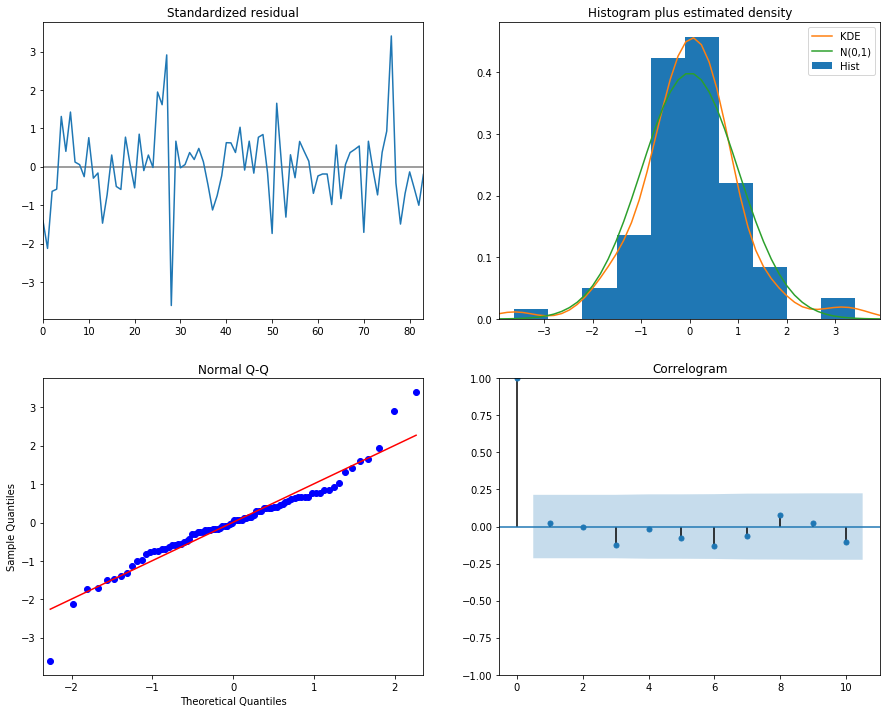

In [32]:
arima_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [33]:
#We forecast the data
future_forecast = arima_fit.predict(n_periods=12)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Kales_Prediction'])
act_vs_predict=pd.concat([test,future_forecast],axis=1)
act_vs_predict = act_vs_predict.round(decimals=2)
act_vs_predict.tail(12)

,Kales,Kales_Prediction
Date,,
2020-01-01,14.35,21.63
2020-02-01,24.00,28.51
2020-03-01,18.00,31.20
2020-04-01,22.00,32.14
2020-05-01,20.00,30.10
2020-06-01,22.00,31.06
2020-07-01,20.00,27.76
2020-08-01,22.00,24.93
2020-09-01,18.00,23.92


In [34]:
act_vs_predict['diff']=act_vs_predict['Kales']-act_vs_predict['Kales_Prediction']
act_vs_predict

,Kales,Kales_Prediction,diff
Date,,,
2020-01-01,14.35,21.63,-7.28
2020-02-01,24.00,28.51,-4.51
2020-03-01,18.00,31.20,-13.20
2020-04-01,22.00,32.14,-10.14
2020-05-01,20.00,30.10,-10.10
2020-06-01,22.00,31.06,-9.06
2020-07-01,20.00,27.76,-7.76
2020-08-01,22.00,24.93,-2.93
2020-09-01,18.00,23.92,-5.92


In [35]:
act_vs_predict.min()

Kales               14.00
Kales_Prediction    21.63
diff               -13.20
dtype: float64

In [36]:
act_vs_predict.max()

Kales               24.00
Kales_Prediction    32.14
diff                -2.16
dtype: float64

In [37]:
#index = pd.date_range(start="2021-01-01",end="2021-12-01",periods=12)
index_date =['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
             '2020-09-01', '2020-10-01', '2020-11-01','2020-12-01',
             '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
             '2021-09-01', '2021-10-01', '2021-11-01','2021-12-01']
index = pd.to_datetime(index_date)
index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', freq=None)

In [38]:
kales=pd.DataFrame()
kales['Date']= index
kales=kales.set_index(index)

In [39]:
predict= arima_fit.predict(n_periods=24)
predict= pd.DataFrame(predict,index=kales.index,columns=['Forecast'])
predict = predict.round(decimals=2)
predict.head()

,Forecast
2020-01-01,21.63
2020-02-01,28.51
2020-03-01,31.20
2020-04-01,32.14
2020-05-01,30.10


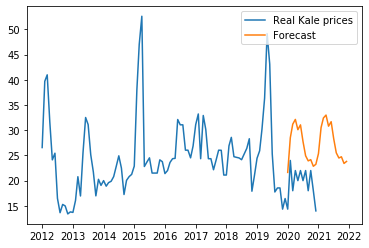

In [40]:
#plot the predictions for validation set
plt.plot(Kales, label='Real Kale prices')
plt.plot(predict, label='Forecast')
plt.legend()
plt.show()

In [41]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(act_vs_predict['Kales'], act_vs_predict['Kales_Prediction']))
print('Mean Squared Error:', metrics.mean_squared_error(act_vs_predict['Kales'], act_vs_predict['Kales_Prediction']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(act_vs_predict['Kales'], 
                                                                     act_vs_predict['Kales_Prediction'])))

Mean Absolute Error: 7.262499999999999
Mean Squared Error: 62.65885833333334
Root Mean Squared Error: 7.915734857442696


In [42]:
best_model = SARIMAX(df_Kales, order=(1,0,1), seasonal_order=(1,1,1,12)).fit(dis=-1)
print(best_model.summary())

C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              Kales   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -267.655
Date:                            Fri, 11 Jun 2021   AIC                            545.311
Time:                                    12:06:43   BIC                            557.465
Sample:                                01-01-2012   HQIC                           550.197
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4876      0.113      4.313      0.000       0.266       0.709
ma.L1          0.3392      0.172   

HOLT'S WINTERS

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

model = HWES(df_Kales, seasonal_periods=12,seasonal='mul')
fitted = model.fit()

C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [44]:
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   96
Model:             ExponentialSmoothing   SSE                           3378.902
Optimized:                         True   AIC                            369.852
Trend:                             None   BIC                            405.753
Seasonal:                Multiplicative   AICC                           376.738
Seasonal Periods:                    12   Date:                 Fri, 11 Jun 2021
Box-Cox:                          False   Time:                         12:06:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7368421                alpha                 True
smoothing_seasonal       

In [45]:
forecast_12= fitted.forecast(12)
forecast_12 = pd.DataFrame(forecast_12,index = test.index,columns=['Kales_Prediction'])
predict_12= pd.concat([test,forecast_12],axis=1)
predict_12= predict_12.round(decimals=2)
predict_12

,Kales,Kales_Prediction
Date,,
2020-01-01,14.35,19.03
2020-02-01,24.00,22.74
2020-03-01,18.00,25.75
2020-04-01,22.00,28.41
2020-05-01,20.00,28.14
2020-06-01,22.00,23.11
2020-07-01,20.00,19.29
2020-08-01,22.00,17.28
2020-09-01,18.00,16.79


In [46]:
forecast=fitted.forecast(24)

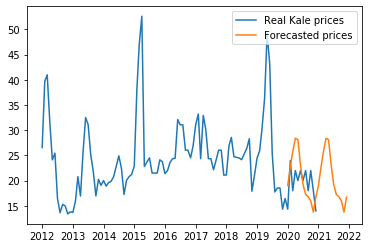

In [47]:
plt.plot(Kales,label='Real Kale prices')
plt.plot(forecast, label='Forecasted prices')
plt.legend()
plt.show()

In [48]:
print('Mean Absolute Error:', metrics.mean_absolute_error(predict_12['Kales'], predict_12['Kales_Prediction']))
print('Mean Squared Error:', metrics.mean_squared_error(predict_12['Kales'], predict_12['Kales_Prediction']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(predict_12['Kales'], 
                                                                     predict_12['Kales_Prediction'])))

Mean Absolute Error: 4.080833333333334
Mean Squared Error: 23.163758333333334
Root Mean Squared Error: 4.812874227873957


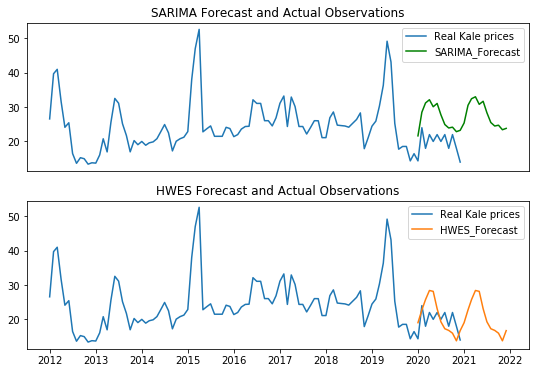

In [49]:
plt.figure(figsize=(9,6))

plt.subplot(211)
plt.title('SARIMA Forecast and Actual Observations')
plt.plot(Kales, label='Real Kale prices')
plt.plot(predict, label='SARIMA_Forecast',color='green')
plt.xticks([])
plt.legend()

plt.subplot(212)
plt.title('HWES Forecast and Actual Observations')
plt.plot(Kales , label='Real Kale prices')
plt.plot(forecast, label='HWES_Forecast')
plt.legend()

plt.show()